#### Variant #3  fsin = 500, fs = 1800

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

fs = 2000
fsin = 600
N = 2 * fs
k = np.arange(0, N)


# case 2
B = 16
Q = 2 ** B
deltaQ = 1 / (Q//2)
x = deltaQ * np.sin(2 * np.pi * fsin / fs * k) # smallest amplitude

In [2]:
def my_quant(x, Q):
    tmp = Q//2  # integer div
    quant_steps = (np.arange(Q) - tmp) / tmp  # we don't use this

    # forward quantization, round() and inverse quantization
    xq = np.round(x*tmp) / tmp
    # always saturate to -1
    xq[xq < -1.] = -1.
    # saturate to ((Q-1) - (Q\2)) / (Q\2), note that \ is integer div
    tmp2 = ((Q-1) - tmp) / tmp  # for odd N this always yields 1
    xq[xq > tmp2] = tmp2
    return xq

In [3]:
def check_my_quant(k, x, Q):
    xq = my_quant(x, Q)
    e = xq - x

    plt.xlim(0, 100)
    plt.plot(k, x, color='C2', lw=3, label=r'$x[k]$')
    plt.plot(k, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(k, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.xlabel('input amplitude')
    plt.ylabel('output amplitude')
    if np.mod(Q, 2) == 0:
        s = ' saturated '
    else:
        s = ' '
    plt.title('uniform'+s+'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e'% (Q, 1/(Q//2)))
    plt.legend(loc='upper left')
    plt.grid(True)

In [4]:
def my_xcorr2(x, y, scaleopt='none'):
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

In [5]:
def check_dithering(x, dither, Q, case):
    deltaQ = 1 / (Q // 2)  # general rule  
    
    # dither noise
    pdf_dither, edges_dither = np.histogram(dither, bins='auto', density=True)
    xd = x + dither  
    
    # quantization
    xq = my_quant(xd, Q)
    e = xq - x
    pdf_error, edges_error = np.histogram(e, bins='auto', density=True)

    # write wavs
    sf.write(file='x_' + case + '.wav', data=x, samplerate=fs, subtype='PCM_24')
    sf.write(file='xd_' + case + '.wav', data=xd, samplerate=fs, subtype='PCM_24')
    sf.write(file='xq_' + case + '.wav', data=xq, samplerate=fs, subtype='PCM_24')
    sf.write(file='e_' + case + '.wav', data=e, samplerate=fs, subtype='PCM_24')

    # CCF
    kappa, ccf = my_xcorr2(xq, e, scaleopt='biased')

    plt.figure(figsize=(12, 3))
    if case == 'no_dither':
        plt.subplot(1, 2, 1)
        # nothing to plot for the zero signal  
        # the PDF would be a weighted Dirac delta at amplitude zero
    else:
        # plot dither noise PDF estimate as histogram
        plt.subplot(1, 2, 1)
        plt.plot(edges_dither[:-1], pdf_dither, 'o-', ms=5)
        plt.ylim(-0.1, np.max(pdf_dither) * 1.1)
        plt.grid(True)
        plt.xlabel(r'$\theta$')
        plt.ylabel(r'$\hat{p}(\theta)$')
        plt.title('PDF Estimate of Dither Noise')

    # plot error noise PDF estimate as histogram
    plt.subplot(1, 2, 2)
    plt.plot(edges_error[:-1], pdf_error, 'o-', ms=5)
    plt.ylim(-0.1, np.max(pdf_error) * 1.1)
    plt.grid(True)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\hat{p}(\theta)$')
    plt.title('PDF Estimate of Error Noise')

    # plot signals
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(k, x, color='C2', label=r'$x[k]$')
    plt.plot(k, xd, color='C1', label=r'$x_d[k] = x[k] + dither[k]$')
    plt.plot(k, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(k, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.plot(k, k * 0 + deltaQ, ':k', label=r'$\Delta Q$')
    plt.xlabel('k')
    plt.title('Signals')
    plt.xticks(np.arange(0, 175, 25))
    plt.xlim(0, 150)
    plt.legend(loc='lower left')
    plt.grid(True)
    
    # plot CCF
    plt.subplot(1, 2, 2)
    plt.plot(kappa, ccf)
    plt.xlabel(r"$\kappa$")
    plt.ylabel(r"$\varphi_{xq,e}[\kappa]$")
    plt.title('CCF between xq and e=xq-x')
    plt.xticks(np.arange(-100, 125, 25))
    plt.xlim(-100, 100)
    plt.grid(True)

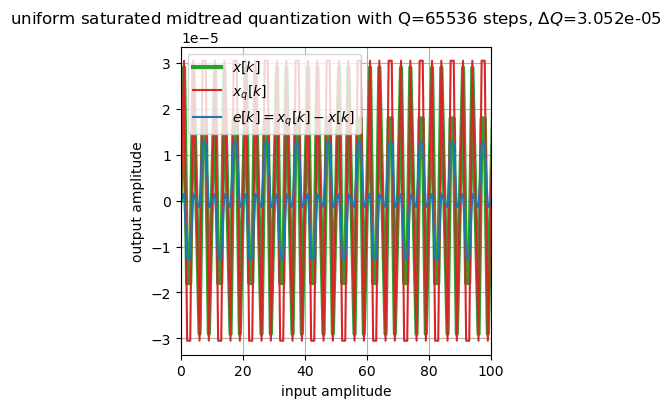

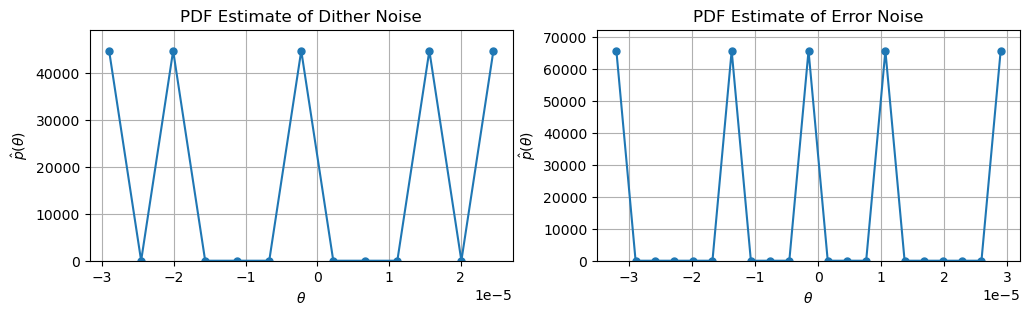

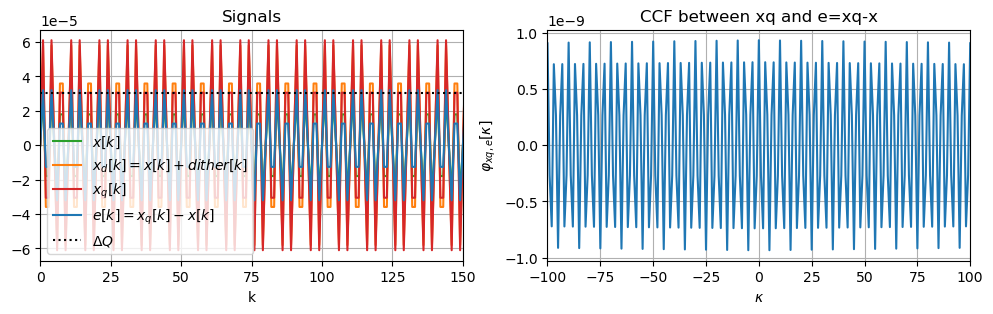

In [6]:
plt.figure(figsize=(4, 4))
check_my_quant(k, x, Q)  # no dither
check_dithering(x=x, dither=x, Q=Q, case='dither')